<a href="https://colab.research.google.com/github/Allen123321/DEMO-DL/blob/master/Task3_Semantic_segmentation_model_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 任务目标
+ 了解语义分割网络模型的发展：FCN 、SegNet、Unet、DeepLab、RefineNet、PSPNet、GAN语义分割。
+ 语义分割模型的使用
+ 语义分割模型的原理和训练过程


### FCN原理及网络结构

FCN首先将一幅RGB图像输入到卷积神经网络后，经过多次卷积以及池化过程得到一系列的特征图，然后利用反卷积层对最后一个卷积层得到的特征图进行上采样，使得上采样后特征图与原图像的大小一样，从而实现对特征图上的每个像素值进行预测的同时保留其在原图像中的空间位置信息，最后对上采样特征图进行逐像素分类，逐个像素计算softmax分类损失。

主要特点：

+ 不含全连接层（FC）的全卷积（Fully Conv）网络。从而可适应任意尺寸输入。

+ 引入增大数据尺寸的反卷积（Deconv）层。能够输出精细的结果。

+ 结合不同深度层结果的跳级（skip）结构。同时确保鲁棒性和精确性。


### SegNet
Segnet是用于进行像素级别图像分割的全卷积网络，分割的核心组件是一个encoder 网络，及其相对应的decoder网络，后接一个象素级别的分类网络。

encoder网络：其结构与VGG16网络的前13层卷积层的结构相似。decoder网络：作用是将由encoder的到的低分辨率的feature maps 进行映射得到与输入图像featuremap相同的分辨率进而进行像素级别的分类。

Segnet的亮点：decoder进行上采样的方式，直接利用与之对应的encoder阶段中进行max-pooling时的polling index 进行非线性上采样，这样做的好处是上采样阶段就不需要进行学习。 上采样后得到的feature maps 是非常稀疏的，因此，需要进一步选择合适的卷积核进行卷积得到dense featuremaps 。

SegNet的思路和FCN十分相似，只是Encoder，Decoder（Unsampling）使用的技术不一样。SegNet的编码器部分使用的是VGG16的前13层卷积网络，每个编码器层都对应一个解码器层，最终解码器的输出被送入soft-max分类器以独立的为每个像素产生类别概率。


Encoder编码器

+ 在编码器处，执行卷积和最大池化。
+ VGG-16有13个卷积层。 （不用全连接的层）
+ 在进行2×2最大池化时，存储相应的最大池化索引（位置）。

Decoder解码器

使用最大池化的索引进行上采样

+ 在解码器处，执行上采样和卷积。最后，每个像素送到softmax分类器。
+ 在上采样期间，如上所示，调用相应编码器层处的最大池化索引以进行上采样。
+ 最后，使用K类softmax分类器来预测每个像素的类别。

### Unet
U-net对称语义分割模型，该网络模型主要由一个收缩路径和一个对称扩张路径组成，收缩路径用来获得上下文信息，对称扩张路径用来精确定位分割边界。U-net使用图像切块进行训练，所以训练数据量远远大于训练图像的数量，这使得网络在少量样本的情况下也能获得不变性和鲁棒性。

+ Encoder：由两个3x3的卷积层（RELU）+2x2的max pooling层（stride=2）反复组成，每经过一次下采样，通道数翻倍；

+ Decoder：由一个2x2的上采样卷积层（RELU）+Concatenation（crop对应的Encoder层的输出feature map然后与Decoder层的上采样结果相加）+2个3x3的卷积层（RELU）反复构成；

+ 最后一层通过一个1x1卷积将通道数变成期望的类别数。


### DeepLab

基于全卷积对称语义分割模型得到的分割结果比较粗糙，忽略了像素与像素之间的空间一致性关系。于是Google提出了一种新的扩张卷积语义分割模型，考虑了像素与像素之间的空间一致性关系，可以在不增加数量的情况下增加感受野。

+ Deeplabv1是由深度卷积网路和概率图模型级联而成的语义分割模型，由于深度卷积网路在重复最大池化和下采样的过程中会丢失很多的细节信息，所以采用扩张卷积算法增加感受野以获得更多上下文信息。考虑到深度卷积网路在图像标记任务中的空间不敏感性限制了它的定位精度，采用了完全连接条件随机场（Conditional Random Field， CRF）来提高模型捕获细节的能力。
+ Deeplabv2予以分割模型增加了ASPP（Atrous spatial pyramid pooling）结构，利用多个不同采样率的扩张卷积提取特征，再将特征融合以捕获不同大小的上下文信息。
+ Deeplabv3语义分割模型，在ASPP中加入了全局平均池化，同时在平行扩张卷积后添加批量归一化，有效地捕获了全局语义信息。
+ DeepLabV3+语义分割模型在Deeplabv3的基础上增加了编-解码模块和Xception主干网路，增加编解码模块主要是为了恢复原始的像素信息，使得分割的细节信息能够更好的保留，同时编码丰富的上下文信息。增加Xception主干网络是为了采用深度卷积进一步提高算法的精度和速度。在inception结构中，先对输入进行11卷积，之后将通道分组，分别使用不同的33卷积提取特征，最后将各组结果串联在一起作为输出。

主要特点：

+ 在多尺度上为分割对象进行带洞空间金字塔池化（ASPP）
+ 通过使用DCNNs（空洞卷积）提升了目标边界的定位
+ 降低了由DCNN的不变性导致的定位准确率

### 使用segmentation_models_pytorch库 优化baseline


In [1]:
! /opt/bin/nvidia-smi

Thu Feb 25 06:44:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!cp /content/drive/MyDrive/dataset/train.zip /content/

In [3]:
!cp /content/drive/MyDrive/dataset/test_a.zip /content/

In [4]:
!cp /content/drive/MyDrive/dataset/test_a_samplesubmit.csv  /content/

In [5]:
!cp /content/drive/MyDrive/dataset/train_mask.csv  /content/

In [ ]:
!unzip /content/train.zip

In [ ]:
!unzip /content/test_a.zip

In [ ]:
!pip install rasterio

In [10]:
import numpy as np
import pandas as pd
import pathlib, sys, os, random, time
import numba, cv2, gc
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

import albumentations as A

import rasterio
from rasterio.windows import Window

def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(512, 512)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

In [12]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

import torchvision
from torchvision import transforms as T
import segmentation_models_pytorch as smp

In [14]:
EPOCHES = 20
BATCH_SIZE = 8
IMAGE_SIZE = 256
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' 

trfm = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(),
    A.GaussNoise(var_limit=(10.0,50.0),always_apply=False, p=0.5)
])

In [15]:
class TianChiDataset(D.Dataset):
    def __init__(self, paths, rles, transform, test_mode=False):
        self.paths = paths
        self.rles = rles
        self.transform = transform
        self.test_mode = test_mode
        
        self.len = len(paths)
        self.as_tensor = T.Compose([
            T.ToPILImage(),
            T.Resize(IMAGE_SIZE),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225]),
        ])
        
    # get data operation
    def __getitem__(self, index):
        img = cv2.imread(self.paths[index])
        if not self.test_mode:
            mask = rle_decode(self.rles[index])
            augments = self.transform(image=img, mask=mask)
            return self.as_tensor(augments['image']), augments['mask'][None]
        else:
            return self.as_tensor(img), ''        
    
    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

In [16]:
train_mask = pd.read_csv('/content/train_mask.csv', sep='\t', names=['name', 'mask'])
train_mask['name'] = train_mask['name'].apply(lambda x: '/content/train/' + x)

img = cv2.imread(train_mask['name'].iloc[0])
mask = rle_decode(train_mask['mask'].iloc[0])

print(rle_encode(mask) == train_mask['mask'].iloc[0])

True


In [17]:
dataset = TianChiDataset(
    train_mask['name'].values,
    train_mask['mask'].fillna('').values,
    trfm, False
)

In [18]:
valid_idx, train_idx = [], []
for i in range(len(dataset)):
    if i % 5 == 0:
        valid_idx.append(i)
    else:
        train_idx.append(i)
        
train_ds = D.Subset(dataset, train_idx)
valid_ds = D.Subset(dataset, valid_idx)

# define training and validation data loaders
loader = D.DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)

vloader = D.DataLoader(
    valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)

In [19]:
def get_model():
    model = smp.UnetPlusPlus(
        encoder_name="efficientnet-b7",
        encoder_weights="imagenet",
        in_channels=3,
        classes=1,
    )
    
    return model

@torch.no_grad()
def validation(model, loader, loss_fn):
    losses = []
    model.eval()
    for image, target in loader:
        image, target = image.to(DEVICE), target.float().to(DEVICE)
        output = model(image)
        loss = loss_fn(output, target)
        losses.append(loss.item())
        
    return np.array(losses).mean()

In [20]:
model = get_model()
model.to(DEVICE);

optimizer = torch.optim.AdamW(model.parameters(),
                  lr=1e-4, weight_decay=1e-3)

class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1., dims=(-2,-1)):

        super(SoftDiceLoss, self).__init__()
        self.smooth = smooth
        self.dims = dims
    
    def forward(self, x, y):
        tp = (x * y).sum(self.dims)
        fp = (x * (1 - y)).sum(self.dims)
        fn = ((1 - x) * y).sum(self.dims)
        
        dc = (2 * tp + self.smooth) / (2 * tp + fp + fn + self.smooth)
        dc = dc.mean()
        return 1 - dc
    
bce_fn = nn.BCEWithLogitsLoss()
dice_fn = SoftDiceLoss()

def loss_fn(y_pred, y_true):
    bce = bce_fn(y_pred, y_true)
    dice = dice_fn(y_pred.sigmoid(), y_true)
    return 0.8*bce+ 0.2*dice

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth


In [21]:
header = r'''
        Train | Valid
Epoch |  Loss |  Loss | Time, m
'''
#          Epoch         metrics            time
raw_line = '{:6d}' + '\u2502{:7.3f}'*2 + '\u2502{:6.2f}'
print(header)

EPOCHES = 20
best_loss = 10
for epoch in range(1, EPOCHES+1):
    losses = []
    start_time = time.time()
    model.train()
    for image, target in tqdm_notebook(loader):
        # if torch.cuda.is_available():
        #     images, target = images.cuda(), target.cuda()          
        image, target = image.to(DEVICE), target.float().to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
            # print(loss.item())
        
    vloss = validation(model, vloader, loss_fn)
    print(raw_line.format(epoch, np.array(losses).mean(), vloss,
                              (time.time()-start_time)/60**1))
    losses = []
    
    if vloss < best_loss:
        best_loss = vloss
        torch.save(model.state_dict(), 'model_best.pth')


        Train | Valid
Epoch |  Loss |  Loss | Time, m




     1│  0.249│  0.181│ 29.75



     2│  0.171│  0.140│ 29.77



     3│  0.147│  0.135│ 29.81



     4│  0.140│  0.135│ 29.83



     5│  0.136│  0.130│ 29.85



     6│  0.131│  0.127│ 29.78



     7│  0.127│  0.125│ 29.83



     8│  0.127│  0.124│ 29.82



     9│  0.122│  0.122│ 29.82



    10│  0.121│  0.126│ 29.81



    11│  0.119│  0.121│ 29.84



    12│  0.117│  0.119│ 29.84



    13│  0.116│  0.119│ 29.75



    14│  0.114│  0.120│ 29.74



    15│  0.113│  0.116│ 29.77



    16│  0.111│  0.117│ 29.73


KeyboardInterrupt: ignored

In [22]:
trfm = T.Compose([
    T.ToPILImage(),
    T.Resize(IMAGE_SIZE),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225]),
])

subm = []

model.load_state_dict(torch.load("/content/model_best.pth"))
model.eval()

UnetPlusPlus(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          64, 16, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          16, 64, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )


In [23]:
test_mask = pd.read_csv('/content/test_a_samplesubmit.csv', sep='\t', names=['name', 'mask'])
test_mask['name'] = test_mask['name'].apply(lambda x: '/content/test_a/' + x)

for idx, name in enumerate(tqdm_notebook(test_mask['name'].iloc[:])):
    image = cv2.imread(name)
    image = trfm(image)
    with torch.no_grad():
        image = image.to(DEVICE)[None]
        score = model(image)[0][0]
        score_sigmoid = score.sigmoid().cpu().numpy()
        score_sigmoid = (score_sigmoid > 0.5).astype(np.uint8)
        score_sigmoid = cv2.resize(score_sigmoid, (512, 512))

        
        # break
    subm.append([name.split('/')[-1], rle_encode(score_sigmoid)])

In [24]:
print(subm[0])

['R05K5826G4.jpg', '21 18 533 18 1045 20 1557 20 2067 26 2579 26 3089 32 3601 32 4111 36 4623 36 5133 40 5645 40 6157 42 6669 42 7179 46 7691 46 8201 50 8713 50 9225 50 9737 50 10247 54 10759 54 11269 58 11781 58 12293 62 12805 62 13315 84 13827 84 14339 96 14851 96 15363 122 15875 122 16385 146 16897 146 17409 164 17921 164 18433 176 18945 176 19457 182 19969 182 20481 196 20993 196 21505 208 22017 208 22529 226 23041 226 23553 240 24065 240 24577 248 25089 248 25601 256 26113 256 26625 270 27137 270 27649 284 28161 284 28673 36 28713 20 28741 226 29185 36 29225 20 29253 226 29697 34 29739 16 29787 210 30209 34 30251 16 30299 210 30721 34 30765 10 30821 210 31233 34 31277 10 31333 210 31747 30 31791 6 31849 212 32259 30 32303 6 32361 212 32775 20 32875 216 33287 20 33387 216 33801 6 33905 216 34313 6 34417 216 34827 2 34941 210 35339 2 35453 210 35977 206 36489 206 37009 202 37521 202 38039 202 38551 202 39075 194 39587 194 40101 202 40613 202 40961 4 41131 204 41473 4 41643 204 41985

In [25]:
subm = pd.DataFrame(subm)
subm.to_csv('/content/result.csv', index=None, header=None, sep='\t')

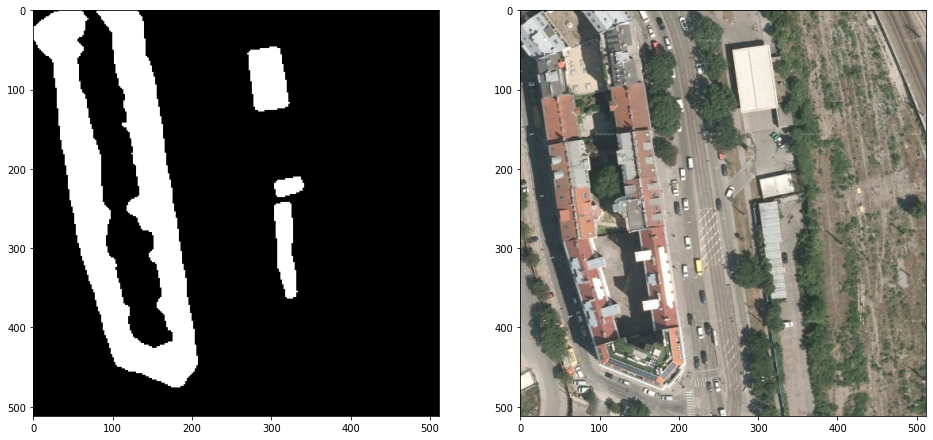

In [28]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(rle_decode(subm[1].fillna('').iloc[0]), cmap='gray')
plt.subplot(122)
plt.imshow(cv2.imread('/content/test_a/' + subm[0].iloc[0]));